## Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [4]:
# Reading in the csv and saving pandas dataframe as a variable 
df = pd.read_csv('../Data/combined.csv')

In [5]:
# viewing the first 5 posts
df.head(5)

,subreddit,title,selftext,title_word_count
0,houseplants,"Not a fan of any Calathea, but this 'Shine Sta...",None,17
1,houseplants,My new marble queen pothos! Welcome to the fam...,None,10
2,houseplants,Moisture meter says it's @ 9. Got it from Cost...,None,37
3,houseplants,Made a couple of trellises today!,None,6
4,houseplants,Made a couple of trellises tonight!,[deleted],6


## Baseline Model

In [8]:
# Lets check the baseline model

df['subreddit'].value_counts(normalize=True)

houseplants       0.500152
InteriorDesign    0.499848
Name: subreddit, dtype: float64

## Converting Target Column to Numerical 0, 1 

In [9]:
# Now we will convert our target column to 0, 1 
# Create label column 
# turning our x into binary labels (numeric)
df['subreddit'] = [1 if x == 'houseplants' else 0 for x in df['subreddit']]

In [10]:
df.shape

(9839, 4)

## Creating X and Y variables

In [11]:
# X is not a matrix (no double brackets)
X =df['title']
y = df['subreddit']

In [12]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [17]:
def grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_w = [None, my_stopwords, 'english'], penalty = ['none', 'l2'], c = [0.2,0.5, 1,2,3], m_iter = [1000], max_d = [1.0], min_d = [1], max_f = [None], accents = [None]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', LogisticRegression())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_w,
                   'vectorizer__max_df': max_d,
                   'vectorizer__min_df': min_d,
                   'vectorizer__max_features': max_f,
                   'vectorizer__strip_accents': accents,
                   'model__penalty': penalty,
                   'model__C': c,
                   'model__max_iter': m_iter
                  }

    # Perform Grid Search
    lr = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = lr.fit(X_train, y_train)
    
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)

    
    return lr

In [18]:
def grid_search_reddit_nb(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_words = [None, 'english', my_stopwords], max_f = [None], min_d= [1], max_d=[.98, .99, .97, 1, 1.0]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', MultinomialNB())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_words,
                   'vectorizer__max_features': max_f,
                   'vectorizer__min_df': min_d,
                   'vectorizer__max_df': max_d
                  }

    # Perform Grid Search
    nb = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = nb.fit(X_train, y_train)
                             
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)
    
    return nb

In [21]:

# Best result
lr = grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_f = [400, None], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1), (1,2)])

Best crossval score: 0.9407
Best TRAIN score: 0.9958
Best TEST score: 0.9433
{'model__C': 10.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


In [22]:
grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_f = [400], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1), (1,2)])

Best crossval score: 0.9047
Best TRAIN score: 0.9185
Best TEST score: 0.9051
{'model__C': 1.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': 400, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__max_iter': [1000], 'model__penalty': ['l2'],
                         'vectorizer__max_df': [1.0],
                         'vectorizer__max_features': [400],
                         'vectorizer__min_df': [1],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)],
                         'vectorizer__stop_words': ['english'],
                         'vectorizer__strip_accents': [None]},
             scoring='accuracy')

### Creating a custom list of stop words to add that are the top words and have the title in them

In [16]:
my_stopwords = list(CountVectorizer(stop_words = 'english').get_stop_words()) + ['plants', 'plant', 'design', 'interior', 'like', 'got', 'just', 'help']

In [28]:
cvec = CountVectorizer(stop_words=my_stopwords)

In [29]:
X_train_cv = cvec.fit_transform(X_train)

In [30]:
X_test_cv = cvec.transform(X_test)

In [31]:
X_train_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())

In [32]:
X_train_df.head(3)

,000,02,03,09,10,100,100hrs,100m2,100x,101,...,𝐑𝐚𝐜𝐤,𝐑𝐢𝐧𝐠,𝐑𝐨𝐛𝐞,𝐒𝐡𝐚𝐦𝐩𝐨𝐨,𝐒𝐭𝐚𝐧𝐝,𝐓𝐨𝐰𝐞𝐥,𝗡𝗲𝘄,𝗯𝗮𝘁𝗵𝗿𝗼𝗼𝗺,𝗻𝗲𝘄,𝘆𝗲𝗮𝗿
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression Model

In [88]:
logreg = LogisticRegression(solver='liblinear')

In [89]:
logreg.fit(X_train_cv, y_train)

LogisticRegression(solver='liblinear')

In [90]:
logreg.score(X_train_cv, y_train), logreg.score(X_test_cv, y_test)

(0.9777002427184466, 0.9174622728672621)

## Random Forest Classifier 

In [91]:
# instantiate the model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

In [19]:
# cross validate score to test for variance
cross_val_score(rfc, X_train_cv, y_train).mean()

0.8763644688750043

In [68]:
# using grid search
rfc_params = { 'n_estimators': [100, 150, 200],
              'max_depth': [None, 1, 2, 3, 4, 5, 10]
              
    
}

In [69]:
grid = GridSearchCV(rfc, param_grid= rfc_params, cv=5, verbose=1)

In [70]:
# Fitting the model
grid.fit(X_train_cv, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  2.8min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 10],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [59]:
grid.best_estimator_

RandomForestClassifier()

In [34]:
grid.best_score_

0.9083732445488547

In [35]:
grid.best_params_

{'max_depth': None, 'n_estimators': 100}

In [36]:
grid.score(X_train_cv, y_train), grid.score(X_test_cv, y_test)

(0.9977245145631068, 0.912842623960579)

In [23]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('nb', MultinomialNB())
])


In [24]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
pipe_params = {
    'cv__max_features': [2_000, 3_000, 4_000, 5_000],
    'cv__min_df': [2, 3],
    'cv__max_df': [.9, .95],
    'cv__ngram_range': [(1,1), (1,2)],
    'cv__stop_words': [None, 'english', my_stopwords ]
}

In [27]:
# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
#
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cv__max_df': [0.9, 0.95],
                         'cv__max_features': [2000, 3000, 4000, 5000],
                         'cv__min_df': [2, 3],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': [None, 'english',
                                            ['whose', 'down', 'first',
                                             'whether', 'into', 'yours',
                                             'together', 'onto', 'thru', 'take',
                                             'have', 'enough', 'whence',
                                             'twelve', 'their', 'everything',
                                             'among', 'toward', 'many',
                                             'otherwise', 'thin', 'much', 'off',
                           

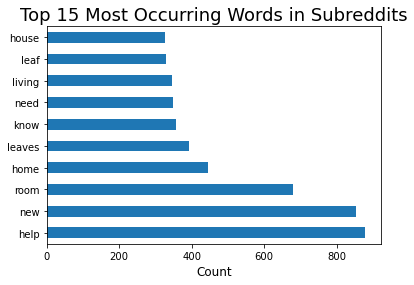

In [86]:
cvec = CountVectorizer(stop_words = my_stopwords)
X = df['title']
cvec.fit(X)
X_trans = cvec.transform(X)

X_df = pd.DataFrame(X_trans.toarray(), 
                           columns=cvec.get_feature_names())

#Observe the top 15 occurring words
plt.title('Top 15 Most Occurring Words in Subreddits', size=18)
plt.xlabel('Count', size=12)
X_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

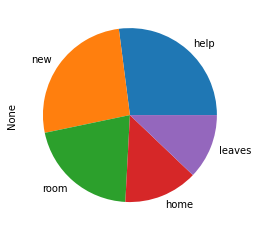

In [87]:

# Creating a pie chart of the top 15 most frequent words

X_df.sum().sort_values(ascending=False).head().plot(kind='pie');

In [95]:
gs.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 4000,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 1),
 'cv__stop_words': 'english'}

## Scoring the Model

In [26]:
gs.score(X_train, y_train)

0.9614684466019418

Scoring on test, unseen data

In [32]:
gs.score(X_test, y_test)

0.9408684939944564

## Confusion Matrix

In [30]:
# predictions for confusion matrix
predictions = gs.predict(X_test)
predictions

array([0, 0, 1, ..., 0, 1, 0])

In [34]:
preds = gs.predict(X_test)

In [35]:
preds

array([0, 0, 1, ..., 0, 1, 0])

In [36]:
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

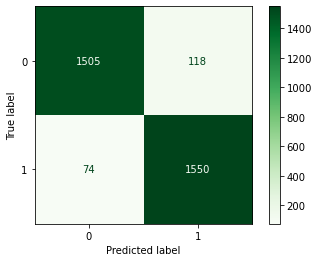

In [37]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Greens', values_format='d');

In [41]:

# Checking what documents were not predicted correctly in the best logistic regression
g_preds = gs.predict(X_test)
check = pd.DataFrame(X_test)
check['y'] = y_test
check['preds'] = g_preds
check['correct'] = check['y'] == check['preds']
check[check['correct'] == False].head(10)
# houseplants = 1 and interior design = 0


,title,y,preds,correct
3267,Plant wall at my salon,1,0,False
8918,What a difference a year makes....,0,1,False
2653,Welcome to the world 🪴,1,0,False
6890,What can I do to fix this?,0,1,False
5038,does anyone here know what these two apps are?...,0,1,False
6928,Barndoor without backerboard,0,1,False
4081,Help❗️Why do these two black corals look so di...,1,0,False
2579,Plant wall shelving ideas? Shelves or a hangin...,1,0,False
9214,This belief,0,1,False
4416,My kitchen//favourite spot to be 🌱,1,0,False


## Model performance metrics

In [103]:
# calculate the specificty 


spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.9272951324707333


## Creating a top 35 most frequent words CSV for Tableau visuals

In [168]:
tvecn_optim = TfidfVectorizer(stop_words = my_stopwords, max_df = 0.25, max_features = 2500, min_df = 2)
X_train_tvecn_optim = tvecn_optim.fit_transform(X_train).todense()
X_train_tvecn_optim_df = pd.DataFrame(X_train_tvecn_optim, columns = tvecn_optim.get_feature_names())
X_train_tvecn_optim.shape

(6592, 2500)

In [1]:
# check for number of words with frequency
new_df = top_df[top_df['Total'] > 5]
len(new_df)

NameError: name 'top_df' is not defined

In [170]:
new_df

,Total
help,330.017509
plant,315.904885
design,304.567841
new,261.172824
interior,257.241344
room,245.612360
plants,190.051532
home,175.994525
just,155.290485
advice,149.305987


In [ ]:
top_df.to_csv('data/top_words.csv')